# Reinforcement Learning (DQN) Tutorial

### CartPole

에이전트는 카트에서 막대기를 떨어뜨리지 않아야 합니다. 그 시간이 길어질수록 보상은 더욱 커집니다. 만약 카트에서 막대기를 떨어뜨리거나, 카트가 중심으로부터 2.4 유닛 이상 움직이게 되면 게임이 끝나게 됩니다.

In [1]:
!pip install gymnasium[classic_control]

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
env = gym.make("CartPole-v1")

In [4]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch. cuda.is_available() else "cpu")

### Replay Memory (재현 메모리)

`Transition` 환경에서 하나의 전환(transition)을 나타내는 네임드 튜플입니다. 이는 (state, action) 쌍을 (next_state, reward) 결과로 매핑합니다.
`ReplayMemory`는 최근 관찰한 전환(transition)을 저장하는 제한된 크기의 순환 버퍼입니다. `.sample()` 메서드를 사용하여 훈련에 사용할 transition의 배치를 임의로 선택합니다.

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN 알고리즘

우리가 사용하는 환경은 결정론적이기 때문에, 사용하는 공식도 모두 결정론적으로 공식화합니다.

우리의 목표는 할인된, 그리고 누적된 보상(또는 결과, return)을 최대화 하는 것입니다.

$$
R_{t_0} = \sum_{t={t_0}}^\infty \gamma^{t-t_0}r_t
$$

$\gamma$가 낮을수록 에이전트는 먼 미래의 불확실한 보상은 비교적 가까운 미래의 확실한 보상보다 덜 중요하게 여깁니다. 또한, 에이전트가 가까운 시점의 보상을, 동일한 양의 미래의 보상보다 먼저 얻을 수 있도록 합니다.

할인 계수 $\gamma$는 합의 수렴을 보장하기 위해 0과 1 사이의 상수여야 합니다. 위 식을 풀어서 쓰면 다음과 같이 됩니다.

$$
S = R_0 + \gamma R_1 + \gamma^2 R_2 + \gamma^3 R_3 + \dots
$$

이 때, $\gamma$가 0과 1사이의 상수라면 양 변에 $\gamma$를 곱한 식에서 위 식을 빼고 정리하면, 다음과 같이 합이 수렴합니다.

$$
S = {{R_0}\over{1-\gamma}}
$$

Q-learning의 핵심 아이디어는 함수 $Q^*: State \times Action \rightarrow ℝ$에 대하여, 주어진 상태에서 어떤 행동을 취한다면, 우리는 보상을 최대화할 수 있는 정책을 다음과 같이 세울 수 있다는 것입니다.

$$
\pi^*(s) = \rm{arg}\max_a Q^*(s, a)
$$

하지만 우리는 모든 것을 알 수 없고, $Q^*$에 도달할 수 없습니다. 하지만 신경망은 범용 함수 근사자(universal function approximator)이기 때문에, 그와 비슷하게 되도록 훈련할 수는 있습니다.

훈련 규칙으로 우리는 매 $Q$ 함수마다 벨만 방정식을 따르도록 할 것입니다.

$$
Q^{\pi}(s, a) = r + \gamma Q^\pi(s', \pi(s'))
$$

두 등식의 차이는 시간차 오류(temporal difference error) $\delta$ 입니다.

$$
\delta = Q(s, a) - (r-\gamma \max_a^{'}Q(s', a))
$$

오차를 최소화하기 위해서 후버 손실을 사용합니다. 후버 손실은 오차가 작을 경우 MSE처럼 동작하고, 오차가 클 경우 MAE처럼 동작합니다. 즉, $Q$의 측정값에 노이즈가 많을 경우 이상치에 강건해진다는 뜻입니다. 우리는 재현 메모리에서 샘플링한 전환의 배치 $B$ 에 대해 이를 게산합니다.

$$
𝓛 = {{1}\over{|B|}} \sum_{(s,a,s',r)\in B} 𝓛(\delta)
$$
<br>
$$
\rm{where} ~~ 𝓛(\delta) = \begin{cases}
{1\over2}\delta^2~~~~~~~~~~\rm{for}~~|\delta|\le1,\\
|\delta| - {1\over2}~~~~~\rm{otherwise}
\end{cases}
$$

### Q-network

모델은 현재와 이전의 스크린 패치(screen patches)의 차이를 취하는 순방향 신경망입니다. 두 개의 출력을 $Q(s, \rm{left})$와 $Q(s, \rm{right})$ (여기서 $s$ 는 네트워크의 입력입니다.) 내어놓습니다. 네트워크는 현재 입력에 대해서 예상되는 결과를 예측합니다.

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 하나의 element 또는 배치와 함께 호출되어 다음 행동을 결정합니다.
    # 최적화 단계에서는 텐서를 반환합니다.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training
### 하이퍼파라미터와 유틸리티

`select_action` 함수는 epsilon greedy 정책에 의해 행동을 선택합니다. 가끔은 모델을 사용하여 행동을 선택하고, 또 때로는 균일 분포를 따르며 하나를 샘플링합니다.
`plot_durations` 함수는 에피소드의 경과를 시각화합니다.

In [8]:
# BATCH_SIZE는 replay buffer에서 샘플링한 transition의 개수입니다.
# GAMMA는 할인 계수입니다
# EPS_START는 epsilon의 초기값입니다.
# EPS_END는 epsilon의 종료값입니다.
# EPS_DECAY는 epslon이 지수적으로 감쇠하는 비율을 조절합니다. 값이 클수록 감쇠가 느립니다.
# TAU는 target network의 update rate입니다.
# LR은 AdamW 옵티마이저의 학습률입니다.

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [9]:
# gym action space에서 행동의 개수를 가져옵니다.
n_actions = env.action_space.n

# 상태 관찰 횟수를 가져옵니다
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [10]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1)는 각 열에서 가장 큰 값을 갖는 행을 반환합니다.
            # max result의 두 번째 행은 max element가 발견된 인덱스입니다.
            # 따라서 우리는 가장 큰 보상을 갖는 행동을 선택합니다.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

In [11]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training ...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(durations_t.numpy())
    # 100 에피소드를 평균하여 시각화합니다.
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) # 표가 업데이트 되도록 잠깐 정비합니다.
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training Loop

`optimize_model` 함수는 최적화의 한 step을 수행합니다. 먼저 배치를 샘플링하고, 하나의 텐서가 되도록 연결(concatenate)합니다. 그리고 $Q(s_t, a_t)$와 $V(s_{t+1})=\max_aQ(s_{t+1}, a)$를 계산한 후, 손실과 결합합니다. 정의에 의해 $V(s)=0$으로 설정하고, $s$ 는 종료 상태입니다. 안정성을 더하기 위해 목표 네트워크를 사용하여 $V(s_{t+1})$를 계산합니다. 목표 네트워크는 매 스텝마다 업데이트 되며 TAU 파라미터에 의해 조절되어 soft update 됩니다.

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)

    # 배치를 전치합니다.
    batch = Transition(*zip(*transitions))

    # 최종이 아닌 상태의 마스크를 계산하고 배치의 각 요소들을 연결합니다.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)

    print(batch.state)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q(s_t, a)를 계산합니다 - 모델은 Q(s_t)를 계산하고, 취한 행동에 대한 컬럼을 선택합니다.
    # 이는 policy_net에 따라 각 배치 상태에서 취한 행동입니다.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 모든 다음 상태에 대한 V(s_{t+1})를 계산합니다.
    # non_final_next_state에 대하여 기대되는 값은 이전의 target_net에 기반하여 계산됩니다.
    # max(1)[0]에 의해 선택된 값입니다. 이는 마스크를 기반으로 병합되어 예상되는 상태의 값이나 최종 상태일 경우 0이 됩니다.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states.max(1)[0])
        # 예상되는 Q 값을 계산합니다.
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Huber Loss를 계산합니다.
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # 모델을 최적화합니다.
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()


아래는 훈련 루프입니다. 먼저 환경을 초기화하고 최초 상태에 대한 텐서를 얻습니다. 그리고 행동을 샘플링하고 실행합니다. 다음 상태와 보상을 관찰합니다. (보상은 항상 1입니다.) 그리고 모델을 한 번 최적화합니다. 에피소드가 끝나면, 반복을 다시 시작합니다.

In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


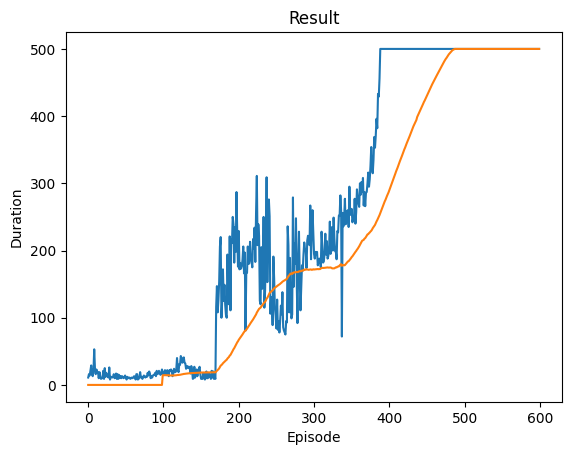

<Figure size 640x480 with 0 Axes>

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [14]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episodes in range(num_episodes):
    # 환경을 초기화하고 그에 대한 상태를 가져옵니다.
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 전환을 메모리에 저장합니다.
        memory.push(state, action, next_state, reward)

        # 다음 상태로 이동합니다.
        state = next_state

        # 정책 네트워크 최적화를 한 단계 수행합니다.
        optimize_model()

        # 목표 네트워크의 가중치를 소프트 업데이트합니다.
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print("Complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()